# Import libraries

In [ ]:
# General libraries
import gc
import json
from model import FF
import numpy as np
%pip install -q --upgrade git+https://github.com/Dralliag/opera-python.git
from opera import Mixture
from torch_geometric import seed_everything
from torch_geometric.nn.conv import *

# GraphToolbox
from graphtoolbox.data.dataset import *
from graphtoolbox.models.gnn import *
from graphtoolbox.optim.optimizer import *
from graphtoolbox.training.metrics import *
from graphtoolbox.training.trainer import Trainer
from graphtoolbox.utils.attention import *
from graphtoolbox.utils.helper_functions import *
from graphtoolbox.utils.visualizations import *

# Autoreload
%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Import data

In [2]:
### GLOBAL VARIABLES
DATASET = 'rfrance' # 'rfrance', 'weave'
OPTIMIZE = False
TRAIN = False # whether to train GNNs/FF or just evaluate
OUT_CHANNELS = 48
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
if DATASET == 'weave':
    print("Weave Dataset")
    data_kwargs = {
        'node_var': 'id_unique',
        'dummies': ['instant', 'id_uniqueInt',],
        'day_inf_train': '2024-02-13',
        'day_sup_train': '2024-02-23',
        'day_inf_val': '2024-02-23',
        'day_sup_val': '2024-02-25',
        'day_inf_test': '2024-02-25',
        'day_sup_test': '2024-02-29'
    }

    dataset_kwargs = {
        'adj_matrix': 'dtw',
        'features_base': ['instant', 'id_uniqueInt', 'weekday'] + [f'consumption_l{t}' for t in range(1, 48+1)],
        'target_base': 'consumption',
    }

    nrows, ncols = 4, 7

    data = DataClass(path_train='./data/weave/train_weave.csv', 
                    path_test='./data/weave/test_weave.csv', 
                    data_kwargs=data_kwargs,
                    folder_config='.')

    graph_dataset_train = GraphDataset(data=data, period='train', 
                                    graph_folder='./graph_representations_weave',
                                    dataset_kwargs=dataset_kwargs,
                                    out_channels=OUT_CHANNELS)
    graph_dataset_val = GraphDataset(data=data, period='val', 
                                    scalers_feat=graph_dataset_train.scalers_feat, 
                                    scalers_target=graph_dataset_train.scalers_target,
                                    graph_folder='./graph_representations_weave',
                                    dataset_kwargs=dataset_kwargs,
                                    out_channels=OUT_CHANNELS)
    graph_dataset_test = GraphDataset(data=data, period='test',
                                    scalers_feat=graph_dataset_train.scalers_feat, 
                                    scalers_target=graph_dataset_train.scalers_target,
                                    graph_folder='./graph_representations_weave',
                                    dataset_kwargs=dataset_kwargs,
                                    out_channels=OUT_CHANNELS)
else:
    # print french flag
    
    print("Regional French Dataset")
    data_kwargs = {
        'node_var': 'Region',
        'dummies': ['Instant', 'JourSemaine', 'DayType', 'offset'],
        'day_inf_train': '2015-01-01',
        'day_sup_train': '2018-01-01',
        'day_inf_val': '2018-01-01',
        'day_sup_val': '2018-12-31',
        'day_inf_test': '2019-01-01',
        'day_sup_test': '2019-12-31'
    }

    dataset_kwargs = {
        'adj_matrix': 'dtw',
        'features_base': ['temp', 'nebu', 'wind', 'tempMax', 'tempMin', 'Posan', 'Instant', 'JourSemaine', 'JourFerie', 'offset', 'DayType', 'Weekend', 'temp_liss_fort', 'temp_liss_faible'] + [f'load_l{t}' for t in range(1, 48+1)],
        'target_base': 'load',
    }

    nrows, ncols = 3, 4

    data = DataClass(path_train='./data/rfrance/train2.csv', 
                    path_test='./data/rfrance/test2.csv', 
                    data_kwargs=data_kwargs,
                    folder_config='.')

    graph_dataset_train = GraphDataset(data=data, period='train', 
                                      graph_folder='./graph_representations_rfrance',
                                      dataset_kwargs=dataset_kwargs,
                                      out_channels=OUT_CHANNELS)
    graph_dataset_val = GraphDataset(data=data, period='val', 
                                     scalers_feat=graph_dataset_train.scalers_feat, 
                                     scalers_target=graph_dataset_train.scalers_target,
                                     graph_folder='./graph_representations_rfrance',
                                     dataset_kwargs=dataset_kwargs,
                                     out_channels=OUT_CHANNELS)
    graph_dataset_test = GraphDataset(data=data, period='test',
                                      scalers_feat=graph_dataset_train.scalers_feat, 
                                      scalers_target=graph_dataset_train.scalers_target,
                                      graph_folder='./graph_representations_rfrance',
                                      dataset_kwargs=dataset_kwargs,
                                      out_channels=OUT_CHANNELS)

Regional French Dataset


# GNN Optimization

In [4]:
seed=42
seed_everything(seed)
if OPTIMIZE:
    gnn_opt = Optimizer(model=myGNN, 
                    dataset_train=graph_dataset_train, 
                    dataset_val=graph_dataset_val, 
                    conv_class=GraphSAGE,
                    optim_kwargs={'num_layers': (1, 5),
                                  'hidden_channels': (32, 512),
                                  'lr': (1e-5, 1e-1)
                                  },
                    num_epochs=300)
    gnn_opt.optimize(n_trials=100)

# GNN Training

In [5]:
# Load configs where each top-level key is the conv name
config_path = f'configs/config_{DATASET}.json'
if not os.path.isfile(config_path):
    raise FileNotFoundError(f"Config file not found: {config_path}")

_CONV_MAP = {
    'GCNConv': GCNConv,
    'GATConv': GATConv,
    'GATv2Conv': GATv2Conv,
    'TransformerConv': TransformerConv,
    'TAGConv': TAGConv,
    'ChebConv': ChebConv,
    'APPNP': APPNP,
    'GraphSAGE': GraphSAGE,
}

with open(config_path, 'r') as f:
    raw = json.load(f)

# Build CONFIGS from the new JSON shape
CONFIGS = {}
for model_name, conf in raw.items():
    conv_key = conf.get('conv', model_name)  # use key name if 'conv' not present
    conv_cls = _CONV_MAP[conv_key] if isinstance(conv_key, str) else conv_key
    CONFIGS[model_name] = {
        'adj_matrix': conf['adj_matrix'],
        'conv': conv_cls,
        'params': conf['params'],
    }

print(f"Loaded CONFIGS from {config_path}: {list(CONFIGS.keys())}")

results = []
preds = {}
N = 1  # Number of runs per model
os.makedirs(f"results_{DATASET}", exist_ok=True)

if TRAIN:
    for model_name, cfg in CONFIGS.items():
        conv_class = cfg["conv"]
        adj_matrix = cfg["adj_matrix"]
        graph_dataset_train._set_adj_matrix(adj_matrix=adj_matrix)
        graph_dataset_val._set_adj_matrix(adj_matrix=adj_matrix)
        graph_dataset_test._set_adj_matrix(adj_matrix=adj_matrix)

        params = cfg["params"]
        results_rmse, results_mape = [], []

        for i in range(N):
            print(f"\n--- {model_name} | Run {i+1}/{N} ---")
            gc.collect()
            torch.cuda.empty_cache()

            conv_kwargs = {}
            for k in ["heads", "K", "alpha"]:
                if k in params:
                    conv_kwargs[k] = params[k]

            if conv_class is not GraphSAGE:
                model = myGNN(
                    in_channels=graph_dataset_train.num_node_features,
                    num_layers=params["num_layers"],
                    hidden_channels=params["hidden_channels"],
                    out_channels=OUT_CHANNELS,
                    conv_class=conv_class,
                    conv_kwargs=conv_kwargs
                )

            trainer = Trainer(
                model=model,
                dataset_train=graph_dataset_train,
                dataset_val=graph_dataset_val,
                dataset_test=graph_dataset_test,
                batch_size=params["batch_size"],
                return_attention=False,
                model_kwargs={'lr': params["lr"], 'num_epochs': 50},
                lam_reg=0
            )

            pred_model_test, target_test, edge_index, attention_weights = trainer.train(
                plot_loss=False,
                force_training=True,
                save=False,
                patience=300
            )

            preds[f"{model_name}_run{i}"] = {
                "predictions": pred_model_test,
            }

            rmse = RMSE(preds=pred_model_test.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
            results_rmse.append(rmse)
            mape = MAPE(preds=pred_model_test.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
            results_mape.append(mape)

        results.append({
            "model": model_name,
            "min_rmse": np.min(results_rmse),
            "mean_rmse": np.mean(results_rmse),
            "max_rmse": np.max(results_rmse),
            "std_rmse": np.std(results_rmse),
            "min_mape": np.min(results_mape),
            "mean_mape": np.mean(results_mape),
            "max_mape": np.max(results_mape),
            "std_mape": np.std(results_mape)
        })  
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='mean_rmse')
    # average predictions over runs for each model
    for model_name in CONFIGS.keys():
        all_runs = [preds[f"{model_name}_run{i}"]["predictions"] for i in range(N)]
        avg_pred = torch.mean(torch.stack(all_runs), dim=0)
        preds[f"{model_name}_avg"] = {
            "predictions": avg_pred,
        }

    # compute metrics for averaged predictions
    for model_name in CONFIGS.keys():
        avg_pred = preds[f"{model_name}_avg"]["predictions"]
        rmse = RMSE(preds=avg_pred.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
        mape = 100*MAPE(preds=avg_pred.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
        print(f"{model_name} | Averaged Predictions | RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

    # average predictions over all models
    all_model_preds = [preds[f"{model_name}_avg"]["predictions"] for model_name in CONFIGS.keys()]
    final_avg_pred = torch.mean(torch.stack(all_model_preds), dim=0)
    final_rmse = RMSE(preds=final_avg_pred.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
    final_mape = 100*MAPE(preds=final_avg_pred.sum(dim=0).cpu().detach(), targets=target_test.sum(dim=0).cpu().detach()).item()
    print(f"All Models Averaged Predictions | RMSE: {final_rmse:.4f}, MAPE: {final_mape:.4f}")


Loaded CONFIGS from configs/config_rfrance.json: ['GCNConv', 'GraphSAGE', 'GATConv', 'GATv2Conv', 'TransformerConv', 'ChebConv', 'TAGConv', 'APPNP']


In [6]:
if TRAIN:
    plot_nodes(true=target_test, pred=final_avg_pred, graph_dataset=graph_dataset_test, nrows=nrows, ncols=ncols)

# FF Training

In [7]:
config = f'configs/config_{DATASET}_ff.json'
with open(config, 'r') as f:
    config_dict = json.load(f)

In [8]:
def create_sequences(X, y, mode='train', horizon=48):
    if mode == 'train':
        X_seqs, y_seqs = [], []
        for i in range(len(X)-horizon+1):
            X_seqs.append(X[i])
            y_seqs.append(y[i:i+horizon])
    else:   
        X_seqs, y_seqs = [], []
        for i in range(0, len(X)-horizon+1, horizon):
            X_seqs.append(X[i])
            y_seqs.append(y[i:i+horizon])
    return np.stack(X_seqs), np.stack(y_seqs)

def fit_global_scaler(datasets_train):
    """
    Fit a global MinMaxScaler across ALL regions/nodes (only on TRAIN).

    Args:
        datasets_train (dict[node] = np.ndarray (n_samples, n_features)):
            Train datasets per node.

    Returns:
        MinMaxScaler fitted on all train data.
    """
    scaler = MinMaxScaler()
    all_train = np.concatenate([arr.reshape(-1, arr.shape[-1]) for arr in datasets_train.values()], axis=0)
    scaler.fit(all_train)
    return scaler


def scale_with_global(scaler, datasets):
    """
    Apply the fitted global scaler to datasets (dict of regions).

    Args:
        scaler (MinMaxScaler): fitted global scaler
        datasets (dict[node] = np.ndarray (n_samples, n_features)): data to transform

    Returns:
        dict[node] = scaled np.ndarray
    """
    scaled = {}
    for node, arr in datasets.items():
        scaled[node] = scaler.transform(arr.reshape(-1, arr.shape[-1]))
    return scaled

def plot_errors(err_train, err_val, err_test, metric="mape"):
    """
    Plot side-by-side bar charts of a chosen error metric for train, validation, and test splits.

    This function creates a 1x3 Matplotlib figure with a shared y-axis, where each subplot
    shows the per-node values of the specified error metric from the corresponding DataFrame.
    The DataFrame index is used as x-axis categories (nodes), and the y-axis label is the
    uppercased metric name. The figure layout is tightened and displayed immediately.

    Parameters
    ----------
    err_train : pandas.DataFrame
        DataFrame of node-level error metrics for the training split. Must contain a column
        named by `metric`; the index provides node labels.
    err_val : pandas.DataFrame
        DataFrame of node-level error metrics for the validation split. Must contain a column
        named by `metric`; the index provides node labels.
    err_test : pandas.DataFrame
        DataFrame of node-level error metrics for the test split. Must contain a column
        named by `metric`; the index provides node labels.
    metric : str, optional
        Name of the error metric column to plot (e.g., "mape", "mae", "rmse"), by default "mape".

    Returns
    -------
    None
        Displays the figure and does not return anything.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)
    for ax, df, title in zip(axes, [err_train, err_val, err_test], ["Train", "Validation", "Test"]):
        df[metric].plot(kind="bar", ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Node")
        ax.set_ylabel(metric.upper())
    plt.tight_layout()
    plt.show()

features = graph_dataset_train.features
target = graph_dataset_train.target
forecast_horizon = OUT_CHANNELS

In [9]:
X_train_node = {node: [] for node in data.nodes}
y_train_node = {node: [] for node in data.nodes}
X_val_node = {node: [] for node in data.nodes}
y_val_node = {node: [] for node in data.nodes}
X_test_node = {node: [] for node in data.nodes}
y_test_node = {node: [] for node in data.nodes}

X_train_all = []
y_train_all = []

for node in data.nodes:
    train_r = data.df_train[data.df_train[data.node_var] == node].reset_index(drop=True)[features].values
    y_train_r = data.df_train[data.df_train[data.node_var] == node].reset_index(drop=True)[[target]].values

    X_train_all.append(train_r)
    y_train_all.append(y_train_r)

X_train_all = np.concatenate(X_train_all, axis=0)
y_train_all = np.concatenate(y_train_all, axis=0)

global_scalerX = MinMaxScaler().fit(X_train_all)
global_scalerY = MinMaxScaler().fit(y_train_all)

for node in data.nodes:
    train_r = data.df_train[data.df_train[data.node_var] == node].reset_index(drop=True)[features].values
    val_r   = data.df_val[data.df_val[data.node_var] == node].reset_index(drop=True)[features].values
    test_r  = data.df_test[data.df_test[data.node_var] == node].reset_index(drop=True)[features].values

    y_train_r = data.df_train[data.df_train[data.node_var] == node].reset_index(drop=True)[[target]].values
    y_val_r   = data.df_val[data.df_val[data.node_var] == node].reset_index(drop=True)[[target]].values
    y_test_r  = data.df_test[data.df_test[data.node_var] == node].reset_index(drop=True)[[target]].values

    train_r_scaled = global_scalerX.transform(train_r)
    val_r_scaled   = global_scalerX.transform(val_r)
    test_r_scaled  = global_scalerX.transform(test_r)

    y_train_r_scaled = global_scalerY.transform(y_train_r)
    y_val_r_scaled   = global_scalerY.transform(y_val_r)
    y_test_r_scaled  = global_scalerY.transform(y_test_r)

    X_train_seq, y_train_seq = create_sequences(train_r_scaled, y_train_r_scaled, mode='train', horizon=forecast_horizon)
    X_val_seq, y_val_seq     = create_sequences(val_r_scaled, y_val_r_scaled, mode='test', horizon=forecast_horizon)
    X_test_seq, y_test_seq   = create_sequences(test_r_scaled, y_test_r_scaled, mode='test', horizon=forecast_horizon)

    X_train_node[node] = torch.tensor(X_train_seq, dtype=torch.float32).reshape(-1, len(features))
    y_train_node[node] = torch.tensor(y_train_seq, dtype=torch.float32).reshape(-1, forecast_horizon)
    X_val_node[node]   = torch.tensor(X_val_seq, dtype=torch.float32).reshape(-1, len(features))
    y_val_node[node]   = torch.tensor(y_val_seq, dtype=torch.float32).reshape(-1, forecast_horizon)
    X_test_node[node]  = torch.tensor(X_test_seq, dtype=torch.float32).reshape(-1, len(features))
    y_test_node[node]  = torch.tensor(y_test_seq, dtype=torch.float32).reshape(-1, forecast_horizon)


In [10]:
n_epochs = 10
if DATASET == 'weave':
    nodes = [node for node in data.nodes if node != '06-06 st andrews road n/b_020-STOKE PLACE']
else:
    nodes = data.nodes
results_train = {node: {} for node in nodes}
results_val = {node: {} for node in nodes}
results_test = {node: {} for node in nodes}

individual_preds_train = {}
individual_preds_val = {}
individual_preds_test = {}

individual_true_train = {}
individual_true_val = {}
individual_true_test = {}

if TRAIN:
    for region in tqdm(nodes):
        params = config_dict[region]['params']
        hidden_channels = params['hidden_channels']
        learning_rate = params['lr']
        num_layers = params['num_layers']
        batch_size = params['batch_size']
        X_train = X_train_node[region].to(DEVICE)
        y_train = y_train_node[region].to(DEVICE)
        X_val = X_val_node[region].to(DEVICE)
        y_val = y_val_node[region].to(DEVICE)
        X_test = X_test_node[region].to(DEVICE)
        y_test = y_test_node[region].to(DEVICE)
        scalerY = global_scalerY
        model = FF(
            in_channels=X_train.shape[-1],
            num_layers=num_layers,
            hidden_channels=hidden_channels,
            out_channels=OUT_CHANNELS
        ).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        loss_fn = torch.nn.MSELoss().to(DEVICE)
        loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
            
        best_epoch = 0
        best_val_rmse = float('inf')
        state_dict = None
        best_model_state = state_dict
        if best_model_state is None:
            for epoch in tqdm(range(n_epochs)):
                model.train()
                for X_batch, y_batch in loader:
                    X_batch, y_batch = X_batch.float().to(DEVICE), y_batch.to(DEVICE)
                    y_pred = model(X_batch)
                    loss = loss_fn(y_pred, y_batch)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    y_pred_val = model(X_val)
                    val_rmse = np.sqrt(loss_fn(
                        y_pred_val,
                        y_val
                    ).item())

                    if val_rmse < best_val_rmse:
                        best_val_rmse = val_rmse
                        best_model_state = model.state_dict()

        model.eval()
        model.load_state_dict(best_model_state)

        y_pred_train = model(X_train)
        y_pred_train, y_true_train = scalerY.inverse_transform(y_pred_train.cpu().detach().numpy()), scalerY.inverse_transform(y_train.cpu().detach().numpy())
        individual_preds_train[region] = y_pred_train
        individual_true_train[region] = y_true_train
        results_train[region]['mape'] = 100*MAPE(preds=y_pred_train, targets=y_true_train)
        results_train[region]['rmse'] = RMSE(preds=y_pred_train, targets=y_true_train)

        y_pred_val = model(X_val)
        y_pred_val, y_true_val = scalerY.inverse_transform(y_pred_val.cpu().detach().numpy()), scalerY.inverse_transform(y_val.cpu().detach().numpy())
        individual_preds_val[region] = y_pred_val
        individual_true_val[region] = y_true_val
        results_val[region]['mape'] = 100*MAPE(preds=y_pred_val, targets=y_true_val)
        results_val[region]['rmse'] = RMSE(preds=y_pred_val, targets=y_true_val)

        y_pred_test = model(X_test)
        y_pred_test, y_true_test = scalerY.inverse_transform(y_pred_test.cpu().detach().numpy()), scalerY.inverse_transform(y_test.cpu().detach().numpy())
        individual_preds_test[region] = y_pred_test
        individual_true_test[region] = y_true_test
        results_test[region]['mape'] = 100*MAPE(preds=y_pred_test, targets=y_true_test)
        results_test[region]['rmse'] = RMSE(preds=y_pred_test, targets=y_true_test)

    err_train = pd.DataFrame(results_train).T
    err_val = pd.DataFrame(results_val).T
    err_test = pd.DataFrame(results_test).T
    
    plot_errors(err_train, err_val, err_test, "mape")
    plot_errors(err_train, err_val, err_test, "rmse")

In [11]:
if TRAIN:
    total_preds_train, total_true_train = 0, 0
    total_preds_val, total_true_val = 0, 0
    total_preds_test, total_true_test = 0, 0
    for node in nodes:
        total_preds_train += individual_preds_train[node].ravel()
        total_true_train += individual_true_train[node].ravel()
        total_preds_val += individual_preds_val[node].ravel()
        total_true_val += individual_true_val[node].ravel()
        total_preds_test += individual_preds_test[node].ravel()
        total_true_test += individual_true_test[node].ravel()
    print(100*MAPE(preds=total_preds_train, targets=total_true_train), RMSE(preds=total_preds_train, targets=total_true_train))
    print(100*MAPE(preds=total_preds_val, targets=total_true_val), RMSE(preds=total_preds_val, targets=total_true_val))
    print(100*MAPE(preds=total_preds_test, targets=total_true_test), RMSE(preds=total_preds_test, targets=total_true_test))

# Load results

## GNN

In [12]:
if DATASET == 'weave':
    nodes = ['01_010-PLOWMAN TOWER WESTLAND T1', '01_040-COURTLAND ROAD',
        '01_040-FOLLY BRIDGE', '01_040-NEW CROSS ROAD',
        '01_060-VIOLET WAY', '01_100-MAIN ROAD TOOT BALDON',
        '01_160-BROAD CLOSE TILBURY FARM', '01_180-OLD HIGH STREET RMU 1',
        '02_030-PEGASUS ROAD', '02_060-VIOLET WAY',
        '02_160-BROAD CLOSE TILBURY FARM', '02_180-OLD HIGH STREET RMU 1',
        '03_020-STOKE PLACE', '03_030-PEGASUS ROAD',
        '03_040-COURTLAND ROAD', '03_040-NEW CROSS ROAD',
        '03_060-VIOLET WAY', '03_160-BROAD CLOSE TILBURY FARM',
        '03_180-OLD HIGH STREET RMU 1', '04_010-PLOWMAN TOWER WESTLAND T1',
        '04_030-PEGASUS ROAD', '04_040-COURTLAND ROAD',
        '04_060-VIOLET WAY', '04_080-ASHMOLEON MUSEUM',
        '04_180-OLD HIGH STREET RMU 1', '05_010-PLOWMAN TOWER WESTLAND T1',
        '05_040-COURTLAND ROAD']
    N = 480 
    base_dir = 'results_weave/'
    true_top = torch.from_numpy(graph_dataset_test.dataframe.pivot(
        index='date',
        columns='id_unique',
        values='consumption'
    ).T.values.sum(axis=0))
else:
    nodes = data.nodes
    N = 80
    base_dir = 'results_rfrance/'
    true_top = torch.from_numpy(graph_dataset_test.dataframe.pivot(
        index='date',
        columns='Region',
        values='load'
    ).T.values.sum(axis=0))

conv_classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d != 'FF']
T = len(true_top)

per_model_stats = {}
per_model_avg_preds = {} 

for conv_class in conv_classes:
    folder = os.path.join(base_dir, conv_class)
    if not os.path.isdir(folder):
        continue

    pt_files = sorted([f for f in os.listdir(folder) if f.endswith('.pt')])
    model_runs = []

    for fname in pt_files:
        path = os.path.join(folder, fname)
        try:
            obj = torch.load(path, weights_only=False)
        except Exception:
            continue

        preds_t = torch.as_tensor(obj)
        if preds_t.ndim == 2:
            top_series = preds_t.sum(dim=0)
        else:
            top_series = preds_t.reshape(-1)

        top_series = top_series.detach().cpu().float()
        series_len = min(len(top_series), T)
        if series_len == 0:
            continue

        ts = top_series[:series_len]
        model_runs.append(ts)

    if not model_runs:
        continue

    Tm = min(len(ts) for ts in model_runs)
    aligned = torch.stack([ts[:Tm] for ts in model_runs], dim=0)
    y_true = true_top[:Tm]

    rmse_runs = [RMSE(preds=aligned[i], targets=y_true).item() for i in range(aligned.shape[0])]
    mape_runs = [100 * MAPE(preds=aligned[i], targets=y_true).item() for i in range(aligned.shape[0])]

    avg_pred = aligned.mean(dim=0)
    per_model_avg_preds[conv_class] = avg_pred 

    rmse_avg = RMSE(preds=avg_pred, targets=y_true).item()
    mape_avg = 100 * MAPE(preds=avg_pred, targets=y_true).item()

    per_model_stats[conv_class] = {
        'n_runs': aligned.shape[0],
        'T_used': Tm,
        'rmse_min': float(np.min(rmse_runs)),
        'rmse_mean': float(np.mean(rmse_runs)),
        'rmse_max': float(np.max(rmse_runs)),
        'rmse_std': float(np.std(rmse_runs)),
        'mape_min': float(np.min(mape_runs)),
        'mape_mean': float(np.mean(mape_runs)),
        'mape_max': float(np.max(mape_runs)),
        'mape_std': float(np.std(mape_runs)),
        'rmse_avg_pred': rmse_avg,   
        'mape_avg_pred': mape_avg  
    }

per_model_df = pd.DataFrame.from_dict(per_model_stats, orient='index').sort_values(by='rmse_avg_pred')
per_model_df

,n_runs,T_used,rmse_min,rmse_mean,rmse_max,rmse_std,mape_min,mape_mean,mape_max,mape_std,rmse_avg_pred,mape_avg_pred
GATConv,10,17376,891.553162,1031.144324,1160.400391,85.397516,1.167860,1.356360,1.552316,0.120398,851.550964,1.058412
GraphSAGE,10,17376,915.986938,978.050708,1048.429932,40.467960,1.180636,1.268138,1.388767,0.063946,862.302429,1.092793
GATv2Conv,10,17376,993.618103,1165.321991,1916.458374,254.144458,1.308199,1.654782,3.100596,0.492544,864.149658,1.102269
TransformerConv,10,17376,1000.618286,1083.158185,1193.073853,69.037980,1.332988,1.460488,1.606703,0.091750,881.710388,1.147248
ChebConv,10,17376,949.499023,1028.440790,1106.548706,54.226031,1.251592,1.379846,1.496679,0.089476,888.017334,1.166051
TAGConv,10,17376,967.700867,998.132092,1040.090088,23.621714,1.259178,1.305599,1.366348,0.034622,903.073547,1.156992
GCNConv,10,17376,965.084106,1182.773364,1403.666260,115.930390,1.278498,1.690475,2.208686,0.246412,908.606750,1.210772
APPNP,10,17376,987.332886,1102.315576,1320.531250,111.745464,1.290198,1.454408,1.712514,0.142670,916.665161,1.168741


## FF

In [13]:
if DATASET == 'weave':
    nodes = ['01_010-PLOWMAN TOWER WESTLAND T1', '01_040-COURTLAND ROAD',
        '01_040-FOLLY BRIDGE', '01_040-NEW CROSS ROAD',
        '01_060-VIOLET WAY', '01_100-MAIN ROAD TOOT BALDON',
        '01_160-BROAD CLOSE TILBURY FARM', '01_180-OLD HIGH STREET RMU 1',
        '02_030-PEGASUS ROAD', '02_060-VIOLET WAY',
        '02_160-BROAD CLOSE TILBURY FARM', '02_180-OLD HIGH STREET RMU 1',
        '03_020-STOKE PLACE', '03_030-PEGASUS ROAD',
        '03_040-COURTLAND ROAD', '03_040-NEW CROSS ROAD',
        '03_060-VIOLET WAY', '03_160-BROAD CLOSE TILBURY FARM',
        '03_180-OLD HIGH STREET RMU 1', '04_010-PLOWMAN TOWER WESTLAND T1',
        '04_030-PEGASUS ROAD', '04_040-COURTLAND ROAD',
        '04_060-VIOLET WAY', '04_080-ASHMOLEON MUSEUM',
        '04_180-OLD HIGH STREET RMU 1', '05_010-PLOWMAN TOWER WESTLAND T1',
        '05_040-COURTLAND ROAD']
    N = 459 
    base_dir = 'results_weave/FF'
    true_top = torch.from_numpy(graph_dataset_test.dataframe.pivot(
        index='date',
        columns='id_unique',
        values='consumption'
    ).T.values.sum(axis=0))
else:
    nodes = data.nodes
    N = 492
    base_dir = 'results_rfrance/FF'
    true_top = torch.from_numpy(graph_dataset_test.dataframe.pivot(
        index='date',
        columns='Region',
        values='load'
    ).T.values.sum(axis=0))
    
rmse_top = []
mape_top = []
preds = torch.zeros(N//len(nodes), len(nodes), len(true_top))
for i in range(N//len(nodes)):
    for k, node in enumerate(nodes):
        file_node = os.path.join(base_dir, node, f'FF_{node}_{len(nodes)*i+k}.pt')
        pred_k = torch.load(file_node, weights_only=False).ravel()
        preds[i, k] = torch.as_tensor(pred_k, dtype=torch.float32).to(preds.device)
    rmse_top.append(RMSE(preds=preds[i].sum(axis=0), targets=true_top).item())
    mape_top.append(100*MAPE(preds=preds[i].sum(axis=0), targets=true_top).item())

In [14]:
nodes_list = list(nodes)  
for node in nodes_list:
    node_dir = os.path.join(base_dir, node)
    files = [f for f in os.listdir(node_dir) if f.startswith(f'FF_{node}_') and f.endswith('.pt')]
    forecasts = []
    for f in files:
        obj = torch.load(os.path.join(node_dir, f), weights_only=False)
        t = torch.as_tensor(obj).reshape(-1).cpu().float()
        forecasts.append(t)
    if not forecasts:
        continue
    mean_node = torch.stack(forecasts, dim=0).mean(dim=0)  # (T,)
    idx = nodes_list.index(node)
    preds[:, idx, :] = mean_node.unsqueeze(0).expand(preds.shape[0], -1)
rmse_top_avg = RMSE(preds=preds.sum(axis=1), targets=true_top).item()
mape_top_avg = 100*MAPE(preds=preds.sum(axis=1), targets=true_top).item()
print(f"RMSE (individual runs): {np.mean(rmse_top):.4f} ± {np.std(rmse_top):.4f}, min: {np.min(rmse_top):.4f}, max: {np.max(rmse_top):.4f}")
print(f"MAPE (individual runs): {np.mean(mape_top):.4f} ± {np.std(mape_top):.4f}, min: {np.min(mape_top):.4f}, max: {np.max(mape_top):.4f}")
print(f"RMSE (averaged runs): {rmse_top_avg:.4f}")
print(f"MAPE (averaged runs): {mape_top_avg:.4f}")

RMSE (individual runs): 1192.1788 ± 575.7446, min: 1043.3818, max: 4828.2915
MAPE (individual runs): 1.6255 ± 0.8203, min: 1.4064, max: 6.8006
RMSE (averaged runs): 1045.8806
MAPE (averaged runs): 1.4039


## Persistence

In [15]:
# Persistence baselines (1 day = 48 instants, 7 days = 7*48 instants)

# Build aligned node × time matrices for each split
df_train = graph_dataset_train.dataframe.pivot(
    index='date',
    columns=graph_dataset_train.data.node_var,
    values=graph_dataset_train.target
)
df_val = graph_dataset_val.dataframe.pivot(
    index='date',
    columns=graph_dataset_val.data.node_var,
    values=graph_dataset_val.target
)
df_test = graph_dataset_test.dataframe.pivot(
    index='date',
    columns=graph_dataset_test.data.node_var,
    values=graph_dataset_test.target
)

nodes_order = list(df_test.columns)
df_train = df_train.reindex(columns=nodes_order)
df_val = df_val.reindex(columns=nodes_order)

train_np = df_train.values.T.astype(float)
val_np = df_val.values.T.astype(float)
test_np = df_test.values.T.astype(float)

y_true_test = torch.from_numpy(test_np).float()  # node × T_test

L_train = train_np.shape[1]
L_val = val_np.shape[1]
L_test = test_np.shape[1]
start = L_train + L_val

step = OUT_CHANNELS
lag1 = step
lag7 = 7 * step

if start < lag7:
    raise ValueError(f"Not enough history for 7-day persistence: have {start} instants before test, need {lag7}.")

full_np = np.hstack([train_np, val_np, test_np]) 

persistence_1d = torch.from_numpy(full_np[:, start - lag1 : start - lag1 + L_test]).float()
persistence_7d = torch.from_numpy(full_np[:, start - lag7 : start - lag7 + L_test]).float()

persistence7 = persistence_7d
true_top_vec = y_true_test.sum(dim=0)

rmse_1d = RMSE(preds=persistence_1d.sum(dim=0), targets=true_top_vec).item()
mape_1d = 100 * MAPE(preds=persistence_1d.sum(dim=0), targets=true_top_vec).item()

rmse_7d = RMSE(preds=persistence_7d.sum(dim=0), targets=true_top_vec).item()
mape_7d = 100 * MAPE(preds=persistence_7d.sum(dim=0), targets=true_top_vec).item()

print(f"Persistence 1 day  (48 instants) | RMSE: {rmse_1d:.4f} | MAPE: {mape_1d:.2f}%")
print(f"Persistence 7 days (336 instants)| RMSE: {rmse_7d:.4f} | MAPE: {mape_7d:.2f}%")


Persistence 1 day  (48 instants) | RMSE: 4507.2251 | MAPE: 5.78%
Persistence 7 days (336 instants)| RMSE: 4656.0312 | MAPE: 6.03%


# Experts Aggregation

In [16]:
BASE_DIR = f'results_{DATASET}/'
AGREGATE = True

if AGREGATE:
    conv_classes = [conv_class for conv_class in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, conv_class)) if conv_class != 'FF']
    order = []

    experts_top = {}
    for conv_class in conv_classes:
        folder = os.path.join(BASE_DIR, conv_class)
        for pred_file in os.listdir(folder):
            m = re.search(r"_(\d+)\.pt$", pred_file)
            if not m:
                continue
            idx = int(m.group(1))
            path = os.path.join(folder, pred_file)
            obj = torch.load(path, weights_only=False)
            preds_t = torch.as_tensor(obj)

            if preds_t.ndim == 2:
                top_series = preds_t.sum(dim=0)
            else:
                top_series = preds_t.reshape(-1)

            top_np = top_series.detach().cpu().float().numpy().ravel()
            key = f"{conv_class}_{idx}"
            experts_top[key] = top_np
            order.append((conv_class, idx))

    T_min = min(len(v) for v in experts_top.values()) if experts_top else 0
    experts = pd.DataFrame({k: v[:T_min] for k, v in experts_top.items()})
    experts = experts[[f"{c}_{i}" for (c, i) in sorted(order, key=lambda x: (x[0], x[1]))]]

    target_top = y_true_test.sum(dim=0).detach().cpu().numpy().ravel()[:T_min]
    target = pd.DataFrame({"target": target_top})
    experts.to_csv(os.path.join(BASE_DIR, 'experts_top.csv'))   
    target.to_csv(os.path.join(BASE_DIR, 'target_top.csv'))  

    experts_bottom = {}
    order_bottom = []

    nodes_df = graph_dataset_test.dataframe.pivot(
        index='date',
        columns=graph_dataset_val.data.node_var,
        values=graph_dataset_val.target
    )
    nodes_order = list(nodes_df.columns)

    for conv_class in conv_classes:
        folder = os.path.join(BASE_DIR, conv_class)
        for pred_file in os.listdir(folder):
            m = re.search(r"_(\d+)\.pt$", pred_file)
            if not m:
                continue
            idx = int(m.group(1))
            path = os.path.join(folder, pred_file)
            obj = torch.load(path, weights_only=False)
            preds_t = torch.as_tensor(obj)

            if preds_t.ndim != 2:
                continue

            preds_np = preds_t.detach().cpu().float().numpy()
            n_nodes = min(preds_np.shape[0], len(nodes_order))
            for j in range(n_nodes):
                key = f"{conv_class}_{idx}__{nodes_order[j]}"
                experts_bottom[key] = preds_np[j]
                order_bottom.append((conv_class, idx, nodes_order[j]))

    if experts_bottom:
        T_min_bottom = min(len(v) for v in experts_bottom.values())
        experts_bottom_df = pd.DataFrame({k: v[:T_min_bottom] for k, v in experts_bottom.items()})
        experts_bottom_df = experts_bottom_df[
            [f"{c}_{i}__{n}" for (c, i, n) in sorted(order_bottom, key=lambda x: (x[0], x[1], x[2]))]
        ]
        experts_bottom_df.to_csv(os.path.join(BASE_DIR, 'experts_bottom.csv'))

        target_bottom_df = nodes_df.iloc[:T_min_bottom].copy()
        target_bottom_df.to_csv(os.path.join(BASE_DIR, 'target_bottom.csv'))

## Uniform

In [17]:
# Uniform aggregation
experts_top = pd.read_csv(os.path.join(BASE_DIR, 'experts_top.csv'), index_col=0)
target_top = pd.read_csv(os.path.join(BASE_DIR, 'target_top.csv'), index_col=0)
avg_pred_top = experts_top.mean(axis=1).values
print(RMSE(preds=avg_pred_top, targets=target_top['target'].values).item())
print(100*MAPE(preds=avg_pred_top, targets=target_top['target'].values).item())

836.2491624655513
1.0618739788336191


## Top

In [18]:
# Top level aggregation
experts_top = pd.read_csv(f'results_{DATASET}/experts_top.csv', index_col=0)
target_top = pd.read_csv(f'results_{DATASET}/target_top.csv', index_col=0)

X = experts_top  # T × K
y = target_top['target'].values.astype(float)  # (T,)
n_instants, n_experts = X.shape
step = OUT_CHANNELS

predictions_top = np.empty(n_instants, dtype=float)
w0 = np.ones(n_experts) / n_experts
predictions_top[:step] = X.iloc[:step].values @ w0

mixture = Mixture(
    y=y[:step],
    experts=X.iloc[:step],
    model="MLpol",
    loss_type="mse",
)

for s in range(step, n_instants, step):
    e = min(s + step, n_instants)
    X_blk = X.iloc[s:e]
    y_blk = y[s:e]
    pred_blk = mixture.predict(new_experts=X_blk)
    predictions_top[s:e] = np.ravel(pred_blk)
    mixture.update(new_experts=X_blk, new_y=y_blk)

print(RMSE(preds=predictions_top, targets=true_top.numpy()))
print(100*MAPE(preds=predictions_top, targets=true_top.numpy()))


807.649743230258
1.0204130990452565


5 most influential experts and their average weights:
1. GATConv_26 (mean weight = 0.1980)
2. GATv2Conv_35 (mean weight = 0.1107)
3. GraphSAGE_33 (mean weight = 0.1006)
4. GraphSAGE_25 (mean weight = 0.0764)
5. GATConv_66 (mean weight = 0.0695)


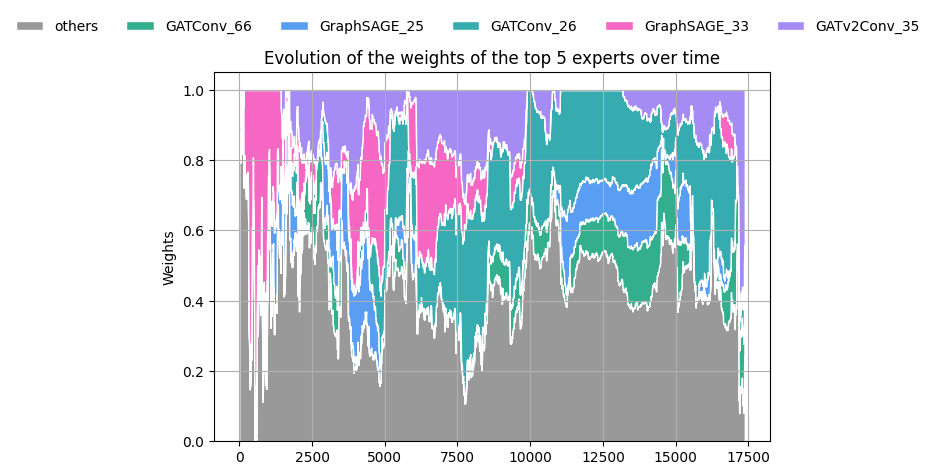

In [19]:
# View most influential experts in the top-level mixture
max_experts = 5
W = mixture.weights 
mean_weights = np.mean(W, axis=0)
top_indices = np.argsort(mean_weights)[::-1][:max_experts]
top_experts = np.array(mixture.experts_names)[top_indices]

print(f"{max_experts} most influential experts and their average weights:")
for i, name in enumerate(top_experts, 1):
    print(f"{i}. {name} (mean weight = {mean_weights[top_indices[i-1]]:.4f})")

colors = sns.color_palette("husl", W.shape[1])
rng = np.random.default_rng(seed=0) 
rng.shuffle(colors)
mixture.plot_mixture(
    plot_type="plot_weight",
    colors=colors,
    max_experts=max_experts,
    title=f"Evolution of the weights of the top {max_experts} experts over time",
    ylabel="Weights",
)

## Bottom-up

In [20]:
# Bottom-up aggregation
experts_bottom = pd.read_csv(f'results_{DATASET}/experts_bottom.csv', index_col=0)
target_bottom = pd.read_csv(f'results_{DATASET}/target_bottom.csv', index_col=0)
nodes_list = list(target_bottom.columns)

T = len(experts_bottom)          
step = OUT_CHANNELS                
predictions_bottom = pd.DataFrame(index=experts_bottom.index, columns=nodes_list, dtype=float)

mixtures_bottom = {}
for node in nodes_list:
    cols_node = [c for c in experts_bottom.columns if c.endswith(f"__{node}")]
    if not cols_node:
        continue

    X_node = experts_bottom[cols_node]                 # T × K_node (DataFrame)
    y_node = target_bottom[node].values.astype(float)  # (T,)
    K_node = X_node.shape[1]
    w0 = np.ones(K_node) / K_node
    pred_node = np.empty(T, dtype=float)
    pred_node[:step] = X_node.iloc[:step].values @ w0

    node_mixture = Mixture(
        y=y_node[:step],
        experts=X_node.iloc[:step],
        model="MLpol",
        loss_type="mse",
    )

    for s in range(step, T, step):
        e = min(s + step, T)
        X_blk = X_node.iloc[s:e]
        y_blk = y_node[s:e]
        pred_blk = node_mixture.predict(new_experts=X_blk)
        pred_node[s:e] = np.ravel(pred_blk)
        node_mixture.update(new_experts=X_blk, new_y=y_blk)

    predictions_bottom[node] = pred_node
    mixtures_bottom[node] = node_mixture

prediction_bottom_up = predictions_bottom.sum(axis=1).values
print(RMSE(preds=prediction_bottom_up, targets=true_top.numpy()))
print(100*MAPE(preds=prediction_bottom_up, targets=true_top.numpy()))

789.3882214954278
1.0057827529478405


Node: Auvergne_Rhone_Alpes
5 most influential experts and their average weights:
1. TAGConv_78__Auvergne_Rhone_Alpes (mean weight = 0.1911)
2. GATConv_26__Auvergne_Rhone_Alpes (mean weight = 0.0806)
3. APPNP_39__Auvergne_Rhone_Alpes (mean weight = 0.0787)
4. ChebConv_53__Auvergne_Rhone_Alpes (mean weight = 0.0696)
5. GraphSAGE_33__Auvergne_Rhone_Alpes (mean weight = 0.0693)


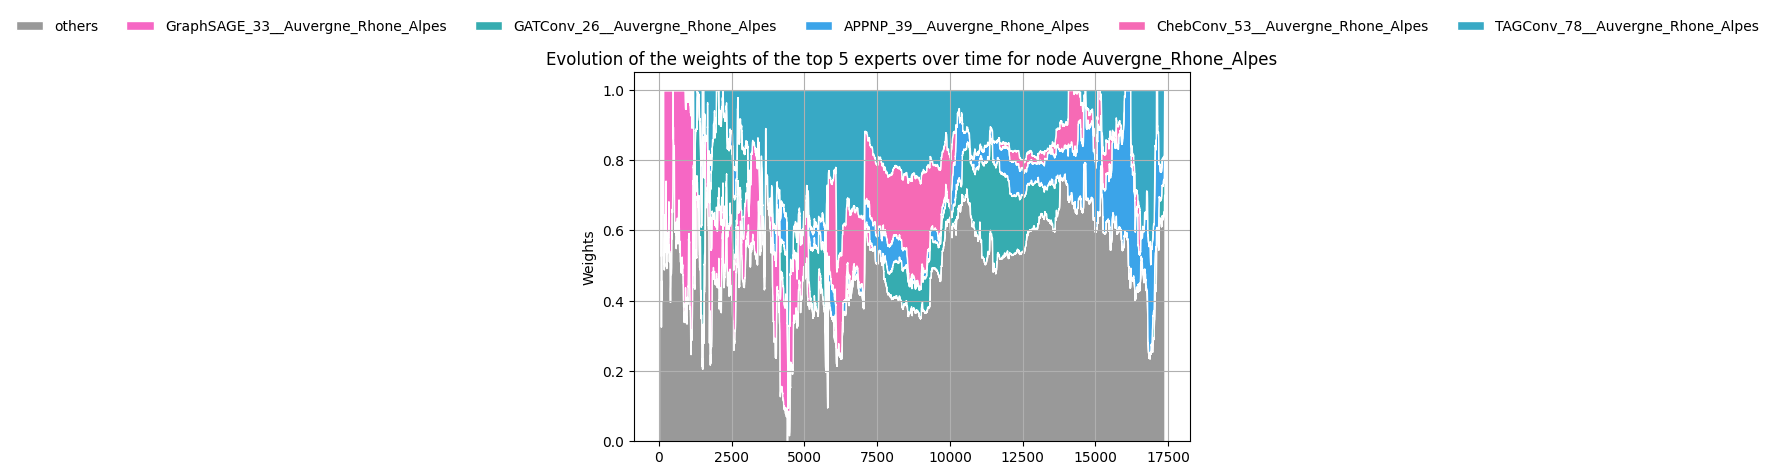

Node: Bourgogne_Franche_Comte
5 most influential experts and their average weights:
1. GATv2Conv_75__Bourgogne_Franche_Comte (mean weight = 0.1045)
2. ChebConv_69__Bourgogne_Franche_Comte (mean weight = 0.0998)
3. TAGConv_46__Bourgogne_Franche_Comte (mean weight = 0.0887)
4. GATv2Conv_67__Bourgogne_Franche_Comte (mean weight = 0.0843)
5. GCNConv_64__Bourgogne_Franche_Comte (mean weight = 0.0712)


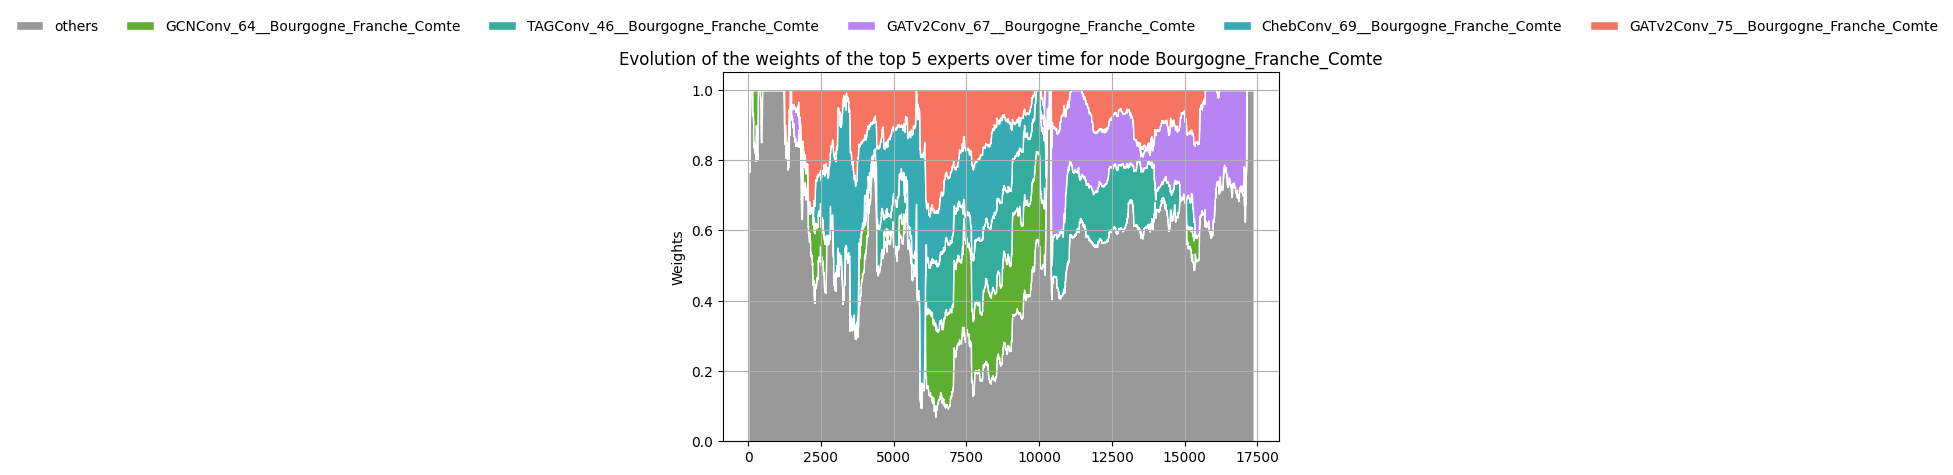

Node: Bretagne
5 most influential experts and their average weights:
1. GATv2Conv_35__Bretagne (mean weight = 0.1828)
2. ChebConv_45__Bretagne (mean weight = 0.0856)
3. GraphSAGE_17__Bretagne (mean weight = 0.0787)
4. GCNConv_64__Bretagne (mean weight = 0.0785)
5. ChebConv_69__Bretagne (mean weight = 0.0620)


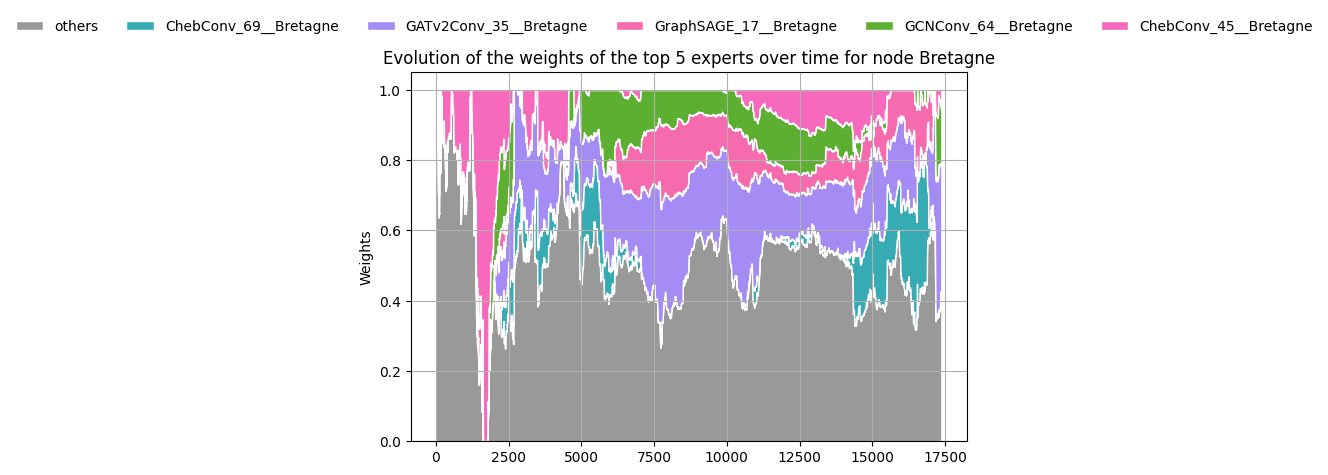

In [21]:
# View most influential experts in the first K bottom-up mixtures
max_experts = 5
num_mixtures = 3
for node in nodes_list[:num_mixtures]:
    mixture = mixtures_bottom.get(node)
    if mixture is None:
        continue

    W = mixture.weights 
    mean_weights = np.mean(W, axis=0)
    top_indices = np.argsort(mean_weights)[::-1][:max_experts]
    top_experts = np.array(mixture.experts_names)[top_indices]

    print(f"Node: {node}")
    print(f"{max_experts} most influential experts and their average weights:")
    for i, name in enumerate(top_experts, 1):
        print(f"{i}. {name} (mean weight = {mean_weights[top_indices[i-1]]:.4f})")

    colors = sns.color_palette("husl", W.shape[1])
    rng = np.random.default_rng(seed=0) 
    rng.shuffle(colors)
    mixture.plot_mixture(
        plot_type="plot_weight",
        colors=colors,
        max_experts=max_experts,
        title=f"Evolution of the weights of the top {max_experts} experts over time for node {node}",
        ylabel="Weights",
    )

# Vizualisations

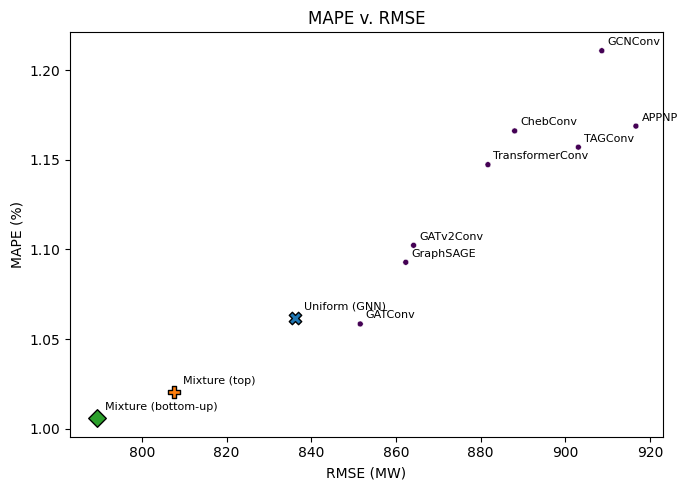

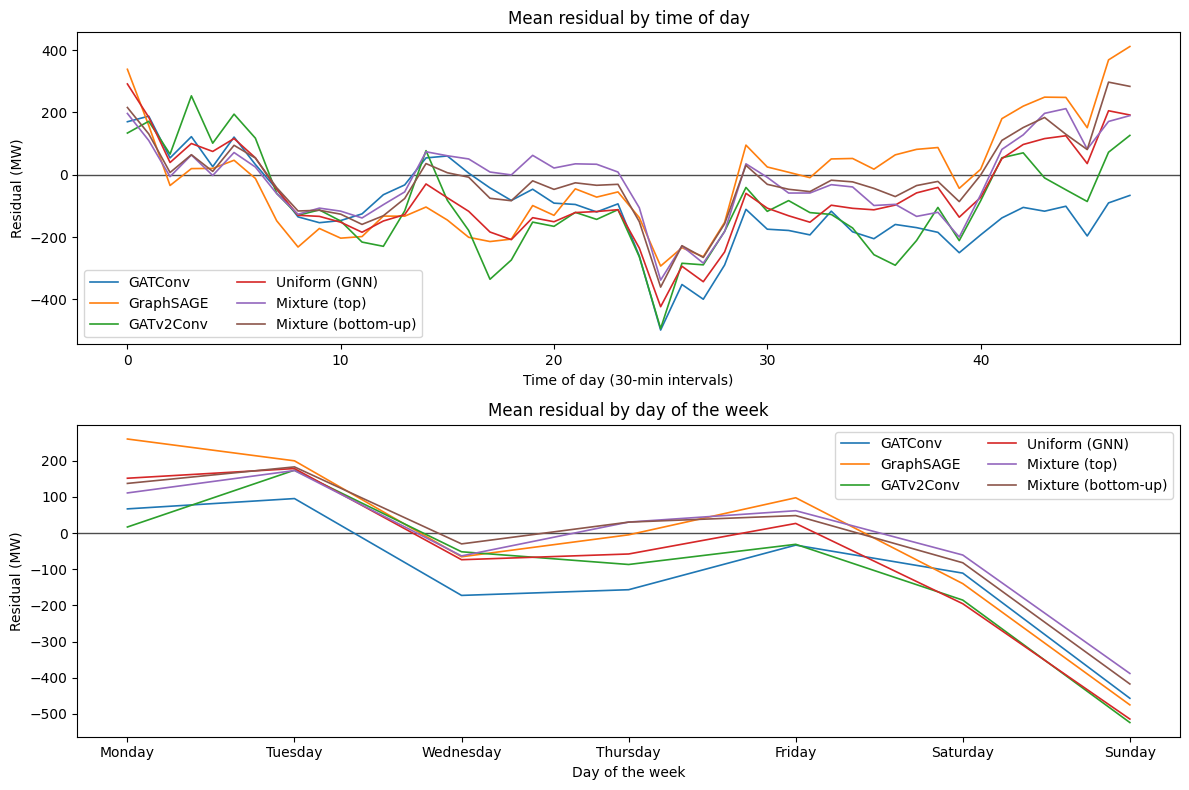

In [22]:
# Vizualisations per-model + aggregations (uniform/mixture) + baselines
df = per_model_df.copy()
df.index.name = 'model'
df = df.reset_index()

true_np = true_top.detach().cpu().numpy()

# Uniform 
uni_np = np.asarray(avg_pred_top, dtype=float)
yt_u, yp_u = true_np[:min(len(true_np), len(uni_np))], uni_np[:min(len(true_np), len(uni_np))]
rmse_uni = RMSE(preds=yp_u, targets=yt_u).item()
mape_uni = 100 * MAPE(preds=yp_u, targets=yt_u).item()

# Mixture top-level
mix_np = np.asarray(predictions_top, dtype=float)
yt_m, yp_m = true_np[:min(len(true_np), len(mix_np))], mix_np[:min(len(true_np), len(mix_np))]
rmse_mix = RMSE(preds=yp_m, targets=yt_m).item()
mape_mix = 100 * MAPE(preds=yp_m, targets=yt_m).item()

# Mixture bottom-up
bu_np = np.asarray(prediction_bottom_up, dtype=float)
yt_bu, yp_bu = true_np[:min(len(true_np), len(bu_np))], bu_np[:min(len(true_np), len(bu_np))]
rmse_bu = RMSE(preds=yp_bu, targets=yt_bu).item()
mape_bu = 100 * MAPE(preds=yp_bu, targets=yt_bu).item()

# 1) 
plt.figure(figsize=(7, 5))
ax = sns.scatterplot(
    data=df, x='rmse_avg_pred', y='mape_avg_pred',
    size='n_runs', hue='n_runs', palette='viridis', legend=False
)
for _, r in df.iterrows():
    ax.annotate(r['model'], (r['rmse_avg_pred'], r['mape_avg_pred']),
                textcoords='offset points', xytext=(4, 4), fontsize=8)

extras = [
    ('Uniform (GNN)', rmse_uni, mape_uni, 'X', 'tab:blue'),
    ('Mixture (top)', rmse_mix, mape_mix, 'P', 'tab:orange'),
    ('Mixture (bottom-up)', rmse_bu, mape_bu, 'D', 'tab:green'),
]
for label, x, y, marker, color in extras:
    ax.scatter(x, y, marker=marker, s=80, color=color, edgecolor='black', zorder=5)
    ax.annotate(label, (x, y), textcoords='offset points', xytext=(6, 6), fontsize=8)

ax.set_xlabel('RMSE (MW)')
ax.set_ylabel('MAPE (%)')
ax.set_title('MAPE v. RMSE')
plt.tight_layout()
plt.show()

# 2) 
best = df.nsmallest(3, 'rmse_avg_pred')['model'].tolist()
Tm = min(
    len(true_np),
    *[len(per_model_avg_preds[m]) for m in best],
    len(uni_np), len(mix_np), len(bu_np),
)
yt = true_np[:Tm]

residuals = {}
for m in best:
    yp = per_model_avg_preds[m][:Tm].detach().cpu().numpy()
    residuals[m] = yp - yt
residuals['Uniform (GNN)'] = uni_np[:Tm] - yt
residuals['Mixture (top)'] = mix_np[:Tm] - yt
residuals['Mixture (bottom-up)'] = bu_np[:Tm] - yt

time_of_day_idx = np.arange(Tm) % step  # 0..47
dow_idx = pd.to_datetime(target_bottom.index[:Tm]).dayofweek.values  # 0..6

def group_means(values, group_idx, n_groups):
    return np.array([
        values[group_idx == g].mean() if np.any(group_idx == g) else np.nan
        for g in range(n_groups)
    ])

daily_means = {k: group_means(v, time_of_day_idx, step) for k, v in residuals.items()}
weekly_means = {k: group_means(v, dow_idx, 7) for k, v in residuals.items()}
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

axes[0].axhline(0.0, color='black', linewidth=1.0, alpha=0.7)
x_day = np.arange(step)
for label, arr in daily_means.items():
    axes[0].plot(x_day, arr, label=label, linewidth=1.2)
axes[0].set_title('Mean residual by time of day')
axes[0].set_xlabel('Time of day (30-min intervals)')
axes[0].set_ylabel('Residual (MW)')
axes[0].legend(ncol=2)

axes[1].axhline(0.0, color='black', linewidth=1.0, alpha=0.7)
x_week = np.arange(7)
for label, arr in weekly_means.items():
    axes[1].plot(x_week, arr, label=label, linewidth=1.2)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[1].set_xticks(x_week)
axes[1].set_xticklabels(day_names)
axes[1].set_title('Mean residual by day of the week')
axes[1].set_xlabel('Day of the week')
axes[1].set_ylabel('Residual (MW)')
axes[1].legend(ncol=2)

plt.tight_layout()
plt.show()